<a href="https://colab.research.google.com/github/fabehashahzad/CNN-model-on-cifar-10/blob/main/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Function to create a MINI CIFAR-10 dataset
def create_mini_cifar10(root='.', train=True, transform=None):
    cifar10_full = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transform)

    # Select the first 150 images in each class
    selected_indices = []
    for class_label in range(10):
        class_indices = [idx for idx, label in enumerate(cifar10_full.targets) if label == class_label]
        selected_indices.extend(class_indices[:150])

    mini_cifar10 = torch.utils.data.Subset(cifar10_full, selected_indices)

    return mini_cifar10

# Define transformations for train
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define transformations for test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Usage
transform_with_tensor = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

mini_cifar10_train = create_mini_cifar10(root='.', train=True, transform=transform_with_tensor)
mini_cifar10_test = create_mini_cifar10(root='.', train=False, transform=transform_with_tensor)

# Split the MINI CIFAR-10 dataset into train, valid, and test sets
total_size = len(mini_cifar10_train)
train_size = int(0.6 * total_size)
valid_size = test_size = (total_size - train_size) // 2

mini_cifar10_train, mini_cifar10_valid, _ = random_split(
    mini_cifar10_train, [train_size, valid_size, total_size - train_size - valid_size]
)

# Usage of dataloaders
train_loader = get_training_dataloader(mini_cifar10_train, train_transform)
valid_loader = get_training_dataloader(mini_cifar10_valid, test_transform)
test_loader = get_testing_dataloader(mini_cifar10_test, test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [112]:
import torch
import torch.nn as nn



#"""Bottleneck layers. Although each layer only produces k
#output feature-maps, it typically has many more inputs. It
#has been noted in [37, 11] that a 1×1 convolution can be in-
#troduced as bottleneck layer before each 3×3 convolution
#to reduce the number of input feature-maps, and thus to
#improve computational efficiency."""
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and
        #we refer to our network with such a bottleneck layer, i.e.,
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments
        #consist of a batch normalization layer and an 1×1
        #convolutional layer followed by a 2×2 average pooling
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution
        #with 16 (or twice the growth rate for DenseNet-BC)
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each
        #side of the inputs is zero-padded by one pixel to keep
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

In [128]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import densenet121
epochs = 30
# learning rate
learning_rate = 0.001
# device to use
# don't forget to turn on GPU on kernel's settings
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model = densenet121()
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy'])
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):

    since = time.time()

    train_accuracy = 0
    top3_train_accuracy = 0
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    time_elapsed = time.time() - since

    valid_loss = 0
    valid_accuracy = 0
    top3_valid_accuracy = 0
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()



            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            valid_loss += batch_loss.item()
                        # Calculate validation top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate validation top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_valid_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(train_loader):.4f}.. "
          f"Train loss: {running_loss/len(train_loader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(train_loader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(train_loader):.4f}.. "
          f"Valid loss: {valid_loss/len(valid_loader):.4f}.. "
          f"Valid accuracy: {valid_accuracy/len(valid_loader):.4f}.. "
          f"Top-3 valid accuracy: {top3_valid_accuracy/len(valid_loader):.4f}")

    train_stats = train_stats.append({
    'Epoch': epoch,
    'Time per epoch': time_elapsed,
    'Avg time per step': time_elapsed/len(train_loader),
    'Train loss': running_loss/len(train_loader),
    'Train accuracy': train_accuracy/len(train_loader),
    'Train top-3 accuracy': top3_train_accuracy/len(train_loader),
    'Test loss': test_loss/len(test_loader),
    'Test accuracy': test_accuracy/len(test_loader),
    'Test top-3 accuracy': top3_test_accuracy/len(test_loader),
    'Valid loss': valid_loss/len(valid_loader),  # Add validation loss
    'Valid accuracy': valid_accuracy/len(valid_loader),  # Add validation accuracy
    'Valid top-3 accuracy': top3_valid_accuracy/len(valid_loader)  # Add validation top-3 accuracy
}, ignore_index=True)

    running_loss = 0
    model.train()

Epoch 1/30.. Time per epoch: 0.8178.. Average time per step: 0.1022.. Train loss: 4.2939.. Train accuracy: 0.1875.. Top-3 train accuracy: 0.4775.. Valid loss: 5.1289.. Valid accuracy: 0.1170.. Top-3 valid accuracy: 0.4034


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 2/30.. Time per epoch: 0.8178.. Average time per step: 0.1022.. Train loss: 1.8100.. Train accuracy: 0.3945.. Top-3 train accuracy: 0.7090.. Valid loss: 2.6518.. Valid accuracy: 0.1619.. Top-3 valid accuracy: 0.4455


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 3/30.. Time per epoch: 1.0326.. Average time per step: 0.1291.. Train loss: 1.6858.. Train accuracy: 0.3701.. Top-3 train accuracy: 0.7168.. Valid loss: 2.2643.. Valid accuracy: 0.1830.. Top-3 valid accuracy: 0.4820


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 4/30.. Time per epoch: 0.7816.. Average time per step: 0.0977.. Train loss: 1.7897.. Train accuracy: 0.3574.. Top-3 train accuracy: 0.6729.. Valid loss: 2.1601.. Valid accuracy: 0.2164.. Top-3 valid accuracy: 0.5211


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 5/30.. Time per epoch: 0.8213.. Average time per step: 0.1027.. Train loss: 1.6377.. Train accuracy: 0.4355.. Top-3 train accuracy: 0.7324.. Valid loss: 2.1799.. Valid accuracy: 0.2495.. Top-3 valid accuracy: 0.5265


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 6/30.. Time per epoch: 0.7860.. Average time per step: 0.0983.. Train loss: 1.5478.. Train accuracy: 0.4385.. Top-3 train accuracy: 0.7861.. Valid loss: 2.0382.. Valid accuracy: 0.2320.. Top-3 valid accuracy: 0.6030


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 7/30.. Time per epoch: 1.0410.. Average time per step: 0.1301.. Train loss: 1.4146.. Train accuracy: 0.4805.. Top-3 train accuracy: 0.8428.. Valid loss: 1.9055.. Valid accuracy: 0.3061.. Top-3 valid accuracy: 0.6572


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 8/30.. Time per epoch: 0.8014.. Average time per step: 0.1002.. Train loss: 1.4039.. Train accuracy: 0.5098.. Top-3 train accuracy: 0.8281.. Valid loss: 1.9332.. Valid accuracy: 0.3494.. Top-3 valid accuracy: 0.6084


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 9/30.. Time per epoch: 0.8005.. Average time per step: 0.1001.. Train loss: 1.1751.. Train accuracy: 0.6035.. Top-3 train accuracy: 0.9111.. Valid loss: 1.9048.. Valid accuracy: 0.2898.. Top-3 valid accuracy: 0.6529


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 10/30.. Time per epoch: 0.9548.. Average time per step: 0.1194.. Train loss: 1.1092.. Train accuracy: 0.5732.. Top-3 train accuracy: 0.9092.. Valid loss: 2.0433.. Valid accuracy: 0.3191.. Top-3 valid accuracy: 0.6139


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 11/30.. Time per epoch: 0.9899.. Average time per step: 0.1237.. Train loss: 0.9874.. Train accuracy: 0.6641.. Top-3 train accuracy: 0.9277.. Valid loss: 1.9849.. Valid accuracy: 0.3402.. Top-3 valid accuracy: 0.6475


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 12/30.. Time per epoch: 0.8567.. Average time per step: 0.1071.. Train loss: 1.2238.. Train accuracy: 0.6074.. Top-3 train accuracy: 0.8457.. Valid loss: 2.0706.. Valid accuracy: 0.3265.. Top-3 valid accuracy: 0.6413


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 13/30.. Time per epoch: 0.7885.. Average time per step: 0.0986.. Train loss: 1.0491.. Train accuracy: 0.6162.. Top-3 train accuracy: 0.9229.. Valid loss: 2.0386.. Valid accuracy: 0.3035.. Top-3 valid accuracy: 0.6158


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 14/30.. Time per epoch: 0.8019.. Average time per step: 0.1002.. Train loss: 1.1484.. Train accuracy: 0.5869.. Top-3 train accuracy: 0.8701.. Valid loss: 2.0067.. Valid accuracy: 0.3035.. Top-3 valid accuracy: 0.6342


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 15/30.. Time per epoch: 0.8025.. Average time per step: 0.1003.. Train loss: 1.3099.. Train accuracy: 0.5283.. Top-3 train accuracy: 0.8125.. Valid loss: 2.1588.. Valid accuracy: 0.2505.. Top-3 valid accuracy: 0.6006


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 16/30.. Time per epoch: 0.7836.. Average time per step: 0.0979.. Train loss: 1.3093.. Train accuracy: 0.5566.. Top-3 train accuracy: 0.8564.. Valid loss: 2.0896.. Valid accuracy: 0.3253.. Top-3 valid accuracy: 0.6416


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 17/30.. Time per epoch: 0.7835.. Average time per step: 0.0979.. Train loss: 1.0845.. Train accuracy: 0.5820.. Top-3 train accuracy: 0.8760.. Valid loss: 2.3907.. Valid accuracy: 0.2505.. Top-3 valid accuracy: 0.5779


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 18/30.. Time per epoch: 1.0742.. Average time per step: 0.1343.. Train loss: 1.2262.. Train accuracy: 0.5273.. Top-3 train accuracy: 0.8418.. Valid loss: 2.2337.. Valid accuracy: 0.3021.. Top-3 valid accuracy: 0.6491


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 19/30.. Time per epoch: 0.7834.. Average time per step: 0.0979.. Train loss: 1.2199.. Train accuracy: 0.5781.. Top-3 train accuracy: 0.8604.. Valid loss: 2.3894.. Valid accuracy: 0.2834.. Top-3 valid accuracy: 0.5928


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 20/30.. Time per epoch: 1.0801.. Average time per step: 0.1350.. Train loss: 1.0185.. Train accuracy: 0.6602.. Top-3 train accuracy: 0.9053.. Valid loss: 2.3098.. Valid accuracy: 0.3108.. Top-3 valid accuracy: 0.6304


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 21/30.. Time per epoch: 0.7782.. Average time per step: 0.0973.. Train loss: 0.9947.. Train accuracy: 0.6641.. Top-3 train accuracy: 0.9102.. Valid loss: 2.3997.. Valid accuracy: 0.2872.. Top-3 valid accuracy: 0.6269


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 22/30.. Time per epoch: 0.7928.. Average time per step: 0.0991.. Train loss: 0.8228.. Train accuracy: 0.7070.. Top-3 train accuracy: 0.9502.. Valid loss: 2.3020.. Valid accuracy: 0.2940.. Top-3 valid accuracy: 0.6117


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 23/30.. Time per epoch: 0.7880.. Average time per step: 0.0985.. Train loss: 0.8565.. Train accuracy: 0.7070.. Top-3 train accuracy: 0.8975.. Valid loss: 2.1175.. Valid accuracy: 0.3736.. Top-3 valid accuracy: 0.7086


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 24/30.. Time per epoch: 0.8084.. Average time per step: 0.1011.. Train loss: 0.8763.. Train accuracy: 0.7295.. Top-3 train accuracy: 0.9092.. Valid loss: 2.1474.. Valid accuracy: 0.3987.. Top-3 valid accuracy: 0.7211


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 25/30.. Time per epoch: 0.9192.. Average time per step: 0.1149.. Train loss: 0.9646.. Train accuracy: 0.6875.. Top-3 train accuracy: 0.8994.. Valid loss: 2.4974.. Valid accuracy: 0.2867.. Top-3 valid accuracy: 0.6473


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 26/30.. Time per epoch: 0.9965.. Average time per step: 0.1246.. Train loss: 1.0828.. Train accuracy: 0.7002.. Top-3 train accuracy: 0.8721.. Valid loss: 2.5469.. Valid accuracy: 0.2891.. Top-3 valid accuracy: 0.5753


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 27/30.. Time per epoch: 0.7919.. Average time per step: 0.0990.. Train loss: 1.1109.. Train accuracy: 0.6445.. Top-3 train accuracy: 0.8721.. Valid loss: 2.5682.. Valid accuracy: 0.3224.. Top-3 valid accuracy: 0.6110


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 28/30.. Time per epoch: 0.7881.. Average time per step: 0.0985.. Train loss: 0.9083.. Train accuracy: 0.6963.. Top-3 train accuracy: 0.9053.. Valid loss: 2.2170.. Valid accuracy: 0.3250.. Top-3 valid accuracy: 0.6598


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 29/30.. Time per epoch: 0.7916.. Average time per step: 0.0990.. Train loss: 0.9935.. Train accuracy: 0.6826.. Top-3 train accuracy: 0.8965.. Valid loss: 3.1085.. Valid accuracy: 0.2753.. Top-3 valid accuracy: 0.5566


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


Epoch 30/30.. Time per epoch: 0.7871.. Average time per step: 0.0984.. Train loss: 0.9715.. Train accuracy: 0.6670.. Top-3 train accuracy: 0.9141.. Valid loss: 2.4929.. Valid accuracy: 0.2969.. Top-3 valid accuracy: 0.6373


<ipython-input-128-9cea78d7fd4c>:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_stats = train_stats.append({


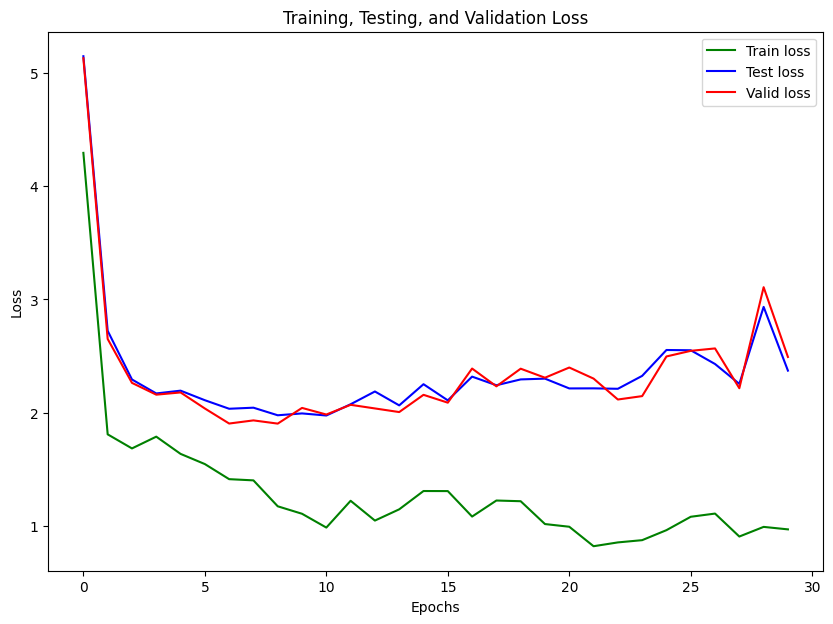

In [129]:
import matplotlib.pyplot as plt

# Assuming `train_stats` is the DataFrame containing your training statistics
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(train_stats['Epoch'], train_stats['Train loss'], '-g', label='Train loss')
ax.plot(train_stats['Epoch'], train_stats['Test loss'], '-b', label='Test loss')
ax.plot(train_stats['Epoch'], train_stats['Valid loss'], '-r', label='Valid loss')

plt.title("Training, Testing, and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
